In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_auc_score
# from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc,accuracy_score
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
# ขั้นตอนการโหลดข้อมูล และแบ่งข้อมูลออกเป็น X และ y
bb_df = pd.read_csv('DataSet/active_inactive_scoms.csv')

In [4]:
data = bb_df.copy()

In [5]:
data = data.sample(frac=0.05, random_state=233)

In [6]:
# แปลงค่า nan ใน Cancel-Date เป็น 0 (ยังไม่ยกเลิก)
data['inactive_date'] = data['inactive_date'].fillna(0)
# สร้างฟีเจอร์ใหม่ จาก Cancel-Date
data['Cancelled'] = (data['inactive_date'] != 0).astype(int)

In [7]:
# 1. Data Preprocessing
# #One-hot encoding column: Package price
# Price group binning

price_bins = [0, 300, 500, 700, 900, 1000]
price_labels = ['price-under-300', 'price-300-499', 'price-500-699', 'price-700-899', 'price-900+']
data['price_group'] = pd.cut(data['package_price'], bins=price_bins, labels=price_labels, include_lowest=True)

dl_speed_bins = [0, 300, 600,1000]
dl_speed_labels = ['speed-under-300', 'speed-300-599', 'speed-600+']
data['dl_speed_group'] = pd.cut(data['dl_speed'], bins=dl_speed_bins, labels=dl_speed_labels, include_lowest=True)

price_group_dummies = pd.get_dummies(data['price_group'])
data = pd.concat([data, price_group_dummies], axis=1)

speed_group_dummies = pd.get_dummies(data['dl_speed_group'])
data = pd.concat([data, speed_group_dummies], axis=1)


In [8]:
data.columns

Index(['circuit_id', 'install_date', 'inactive_date', 'package',
       'package_startdate', 'package_enddate', 'ba_id', 'customer_type_name',
       'acc_type_update', 'org_dep_abbr', 'package_group_name_th',
       'package_info_name', 'start_date_sale_package', 'end_date_sale_package',
       'package_price', 'active_status', 'claims', 'tenure_month', 'ipphone',
       'tv_box', 'WiFi', 'pay_first', 'mobile', 'dl_speed', 'ul_speed',
       'Cancelled', 'price_group', 'dl_speed_group', 'price-under-300',
       'price-300-499', 'price-500-699', 'price-700-899', 'price-900+',
       'speed-under-300', 'speed-300-599', 'speed-600+'],
      dtype='object')

In [9]:
# แบ่งข้อมูลออกเป็น feature และ target
features = data.drop(['circuit_id', 'install_date', 'inactive_date', 'package',
       'package_startdate', 'package_enddate', 'ba_id', 'customer_type_name',
       'acc_type_update', 'org_dep_abbr', 'package_group_name_th',
       'package_info_name', 'start_date_sale_package', 'end_date_sale_package',
        'Cancelled','active_status','price_group','dl_speed_group'], axis=1)
target = data['Cancelled']
# ==============================================

# แบ่งข้อมูลออกเป็น train และ test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [10]:
features

,package_price,claims,tenure_month,ipphone,tv_box,WiFi,pay_first,mobile,dl_speed,ul_speed,price-under-300,price-300-499,price-500-699,price-700-899,price-900+,speed-under-300,speed-300-599,speed-600+
134114,490.0,2,59,0,0,0,1,0,600,600,False,True,False,False,False,False,True,False
126608,290.0,0,121,0,0,0,1,0,300,300,True,False,False,False,False,True,False,False
21869,590.0,0,75,0,0,0,0,0,1000,200,False,False,True,False,False,False,False,True
20627,490.0,0,73,0,0,0,1,0,600,600,False,True,False,False,False,False,True,False
142886,590.0,12,61,0,0,0,1,0,1000,500,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130849,290.0,1,79,0,0,0,1,0,300,300,True,False,False,False,False,True,False,False
145443,590.0,0,71,0,0,0,1,0,1000,300,False,False,True,False,False,False,False,True
76970,200.0,0,57,0,0,0,0,0,200,200,True,False,False,False,False,True,False,False
100069,300.0,0,33,0,0,0,0,0,300,300,True,False,False,False,False,True,False,False


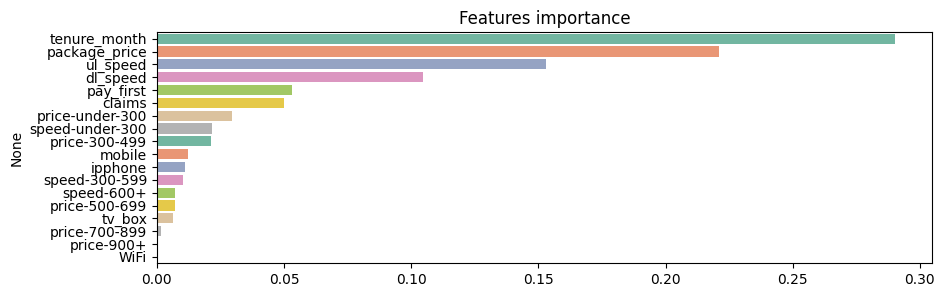

In [11]:
# Feature Importance
# from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=500, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,3))
plt.title("Features importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette="Set2", orient='h')

In [12]:
# สร้างโมเดลจำแนกประเภทด้วย Voting Classifier
rf_clf = RandomForestClassifier(random_state=233)
ls_clf = LinearSVC(random_state=233)
log_clf = LogisticRegression(random_state=233)
dt_clf = DecisionTreeClassifier(random_state=233)
svc_clf = SVC(random_state=233)
xgb_clf = XGBClassifier(random_state=233)
knn_clf = KNeighborsClassifier(n_neighbors = 5)



voting_clf = VotingClassifier(estimators=[('rf',rf_clf),('ls',ls_clf),('lr', log_clf), ('dt', dt_clf),('svc',svc_clf),('xgb',xgb_clf), ('knn', knn_clf)], voting='hard')
# วนลูปสำหรับแต่ละโมเดล
models = [
    ('Random Forest', RandomForestClassifier(random_state=233)),
    # ('Linear SVC', LinearSVC(random_state=233)),
    ('Logistic Regression', LogisticRegression(random_state=233)),
    # ('Decision Tree', DecisionTreeClassifier(random_state=233)),
    # ('Support Vector Machines', SVC(random_state=233)),
    ('XGBoost', XGBClassifier(random_state=233)),
    # ('KNeighbors', KNeighborsClassifier(n_neighbors = 5)),    
    ('Voting Classifier', VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(random_state=233)),('xgb_clf' , XGBClassifier(random_state=233)),
        ('log_clf', LogisticRegression(random_state=233))], voting='hard'))
    # ('Voing Classifier',voting_clf)
]

results = []
for name, model in models:
    
    # ฝึกสอนโมเดล
    model.fit(X_train, y_train)
    
    # ทำนายผลกับข้อมูล test
    y_pred = model.predict(X_test)
    
    # คำนวณ classifier report
    print(f"Classifier Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # คำนวณ ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score for {name}: {roc_auc:.4f}")
    
    # K-Fold Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"K-Fold Cross-Validation Scores for {name}: {cv_scores}")
    print(f"Mean K-Fold Cross-Validation Score for {name}: {cv_scores.mean():.4f}")
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append((name, accuracy, report,roc_auc,cv_scores))
   
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.show()
    

Classifier Report for Random Forest:
              precision    recall  f1-score   support

           0       0.63      0.60      0.62       819
           1       0.60      0.63      0.62       772

    accuracy                           0.62      1591
   macro avg       0.62      0.62      0.62      1591
weighted avg       0.62      0.62      0.62      1591

ROC-AUC Score for Random Forest: 0.6159
K-Fold Cross-Validation Scores for Random Forest: [0.63550668 0.60958366 0.61477987 0.64544025 0.63522013]
Mean K-Fold Cross-Validation Score for Random Forest: 0.6281
Classifier Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       819
           1       0.58      0.58      0.58       772

    accuracy                           0.59      1591
   macro avg       0.59      0.59      0.59      1591
weighted avg       0.59      0.59      0.59      1591

ROC-AUC Score for Logistic Regression: 0.5912
K-Fold Cross

In [13]:
print(cv_scores.mean())

0.6636265050121783


In [14]:
# สร้างตารางเปรียบเทียบผลลัพธ์

print('Comparison of Model Performance:')
print('{:<25}{:<12}{:<12}{:<12}{:<12}{:<12}{:<12}'.format('Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score','ROC-AUC','K-Fold'))
print('-' * 90)
for result in results:
    name, accuracy, report,roc_auc,cv_scores = result
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    cv_scores = cv_scores.mean()
    print('{:<25}{:<12.4f}{:<12.4f}{:<12.4f}{:<12.4f}{:<12.4f}{:<12.4f}'.format(name, accuracy, precision, recall, f1_score,roc_auc,cv_scores))

Comparison of Model Performance:
Model                    Accuracy    Precision   Recall      F1-Score    ROC-AUC     K-Fold      
------------------------------------------------------------------------------------------
Random Forest            0.6153      0.6158      0.6159      0.6153      0.6159      0.6281      
Logistic Regression      0.5915      0.5912      0.5912      0.5912      0.5912      0.6086      
XGBoost                  0.6436      0.6456      0.6449      0.6434      0.6449      0.6600      
Voting Classifier        0.6405      0.6422      0.6416      0.6403      0.6416      0.6636      


In [15]:
features

,package_price,claims,tenure_month,ipphone,tv_box,WiFi,pay_first,mobile,dl_speed,ul_speed,price-under-300,price-300-499,price-500-699,price-700-899,price-900+,speed-under-300,speed-300-599,speed-600+
134114,490.0,2,59,0,0,0,1,0,600,600,False,True,False,False,False,False,True,False
126608,290.0,0,121,0,0,0,1,0,300,300,True,False,False,False,False,True,False,False
21869,590.0,0,75,0,0,0,0,0,1000,200,False,False,True,False,False,False,False,True
20627,490.0,0,73,0,0,0,1,0,600,600,False,True,False,False,False,False,True,False
142886,590.0,12,61,0,0,0,1,0,1000,500,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130849,290.0,1,79,0,0,0,1,0,300,300,True,False,False,False,False,True,False,False
145443,590.0,0,71,0,0,0,1,0,1000,300,False,False,True,False,False,False,False,True
76970,200.0,0,57,0,0,0,0,0,200,200,True,False,False,False,False,True,False,False
100069,300.0,0,33,0,0,0,0,0,300,300,True,False,False,False,False,True,False,False


In [16]:
# สมมติว่าเราใช้ XGBoost เป็นโมเดลที่ดีที่สุด
best_class_model = XGBClassifier()
best_class_model.fit(X_train, y_train)

# ทำนายกลุ่มลูกค้าที่มีความเสี่ยงจะยกเลิก
churn_risk = best_class_model.predict(features)
# churn_risk = best_model.predict(X_test)
data['Churn Risk'] = churn_risk
filtered_data_predict = data.loc[(data['active_status'] == 1) & (data['Churn Risk'] == 1),
                                 ['circuit_id', 'package_price', 'tenure_month','pay_first',  'ipphone', 
                                  'tv_box','mobile','dl_speed','ul_speed','claims','active_status','Churn Risk']]
filtered_payfirst_pred = data.loc[(data['pay_first'] == 0) & (data['active_status'] == 1) & (data['Churn Risk'] == 1),
                                ['circuit_id', 'package_price', 'tenure_month','pay_first',  'ipphone', 
                                  'tv_box','mobile','dl_speed','ul_speed','claims','active_status','Churn Risk']]
filtered_phone_pred = data.loc[(data['ipphone'] == 1) & (data['active_status'] == 1) & (data['Churn Risk'] == 1),
                                 ['circuit_id', 'package_price', 'tenure_month','pay_first',  'ipphone', 
                                  'tv_box','mobile','dl_speed','ul_speed','claims','active_status','Churn Risk']]
filtered_tvbox_pred = data.loc[(data['tv_box'] == 1) & (data['active_status'] == 1) & (data['Churn Risk'] == 1),
                                 ['circuit_id', 'package_price', 'tenure_month','pay_first',  'ipphone', 
                                  'tv_box','mobile','dl_speed','ul_speed','claims','active_status','Churn Risk']]
filtered_mobile_pred = data.loc[(data['mobile'] == 1) & (data['active_status'] == 1) & (data['Churn Risk'] == 1),
                                 ['circuit_id', 'package_price', 'tenure_month','pay_first',  'ipphone', 
                                  'tv_box','mobile','dl_speed','ul_speed','claims','active_status','Churn Risk']]
filtered_bundled_pred = data.loc[((data['mobile'] | data['tv_box'] | data['ipphone']) == 1)& 
                                 (data['pay_first']==0) & (data['active_status'] == 1) & (data['Churn Risk'] == 1),
                                 ['circuit_id', 'package_price', 'tenure_month','pay_first',  'ipphone', 
                                  'tv_box','mobile','dl_speed','ul_speed','claims','active_status','Churn Risk']]
# =============================================================================

# ทำนายผลกับข้อมูลทั้งหมด
# y_pred = best_model.predict(features)
# สร้าง DataFrame ใหม่ที่ประกอบด้วยผลการทำนาย
# predictions = pd.DataFrame({
#     'Circuit-ID': data['Circuit-ID'],
#     'Pay-per-Month': data['Pay-per-Month'],
#     'Bundled Services': data['Bundled-IPPhone'] + data['Bundled-TVBox'] + data['Bundled-Mobile'],
#     'Predicted Service Status': y_pred    
# })

# แสดงผลการทำนาย
# predictions


In [17]:
# แสดงกลุ่มลูกค้าที่มีความเสี่ยงจะยกเลิก
filtered_data_predict

,circuit_id,package_price,tenure_month,pay_first,ipphone,tv_box,mobile,dl_speed,ul_speed,claims,active_status,Churn Risk
126814,3452J9825,260.0,33,0,0,0,0,100,100,0,1,1
94553,4377J1577,260.0,36,0,0,0,0,100,100,0,1,1
86764,3531J7443,290.0,37,1,0,0,0,300,300,0,1,1
85781,7471J9641,390.0,69,0,0,0,0,300,300,0,1,1
121186,2240J2818,159.0,27,0,1,0,0,30,30,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
124082,4448J2021,250.0,22,0,0,0,0,250,250,0,1,1
108693,3433J3168,290.0,38,1,0,0,0,300,300,1,1,1
151354,4281J0896,390.0,93,0,0,0,0,300,300,0,1,1
145443,3222J9027,590.0,71,1,0,0,0,1000,300,0,1,1


In [23]:
filtered_data_predict
# สร้างเงื่อนไขเพื่อกรองข้อมูล
condition = (filtered_data_predict['tenure_month'] > 36) & (filtered_data_predict['package_price'] > 500)

# หากลุ่มลูกค้าที่ตรงตามเงื่อนไข
target_customers = filtered_data_predict.loc[condition]
target_customers


,circuit_id,package_price,tenure_month,pay_first,ipphone,tv_box,mobile,dl_speed,ul_speed,claims,active_status,Churn Risk
92810,2420J1777,700.0,72,0,0,0,0,1000,500,0,1,1
143590,3251J8247,590.0,72,0,0,0,0,250,250,0,1,1
82923,2387J9392,590.0,59,0,0,0,0,1000,300,0,1,1
120940,3951J0650,700.0,79,0,0,0,0,1000,500,0,1,1
85963,4576J7203,590.0,69,0,0,0,0,250,250,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
141289,4271J1239,590.0,70,0,0,0,0,1000,200,0,1,1
94543,3937J7938,590.0,67,0,0,0,0,1000,200,0,1,1
106107,5324J6296,590.0,94,0,0,0,0,1000,200,0,1,1
86132,7750J6827,590.0,99,0,0,0,0,1000,200,0,1,1


In [18]:
filtered_payfirst_pred

,circuit_id,package_price,tenure_month,pay_first,ipphone,tv_box,mobile,dl_speed,ul_speed,claims,active_status,Churn Risk
126814,3452J9825,260.0,33,0,0,0,0,100,100,0,1,1
94553,4377J1577,260.0,36,0,0,0,0,100,100,0,1,1
85781,7471J9641,390.0,69,0,0,0,0,300,300,0,1,1
121186,2240J2818,159.0,27,0,1,0,0,30,30,0,1,1
126311,3851J1260,460.0,36,0,0,0,0,500,500,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
85707,4447J1159,200.0,57,0,0,0,0,200,200,0,1,1
86132,7750J6827,590.0,99,0,0,0,0,1000,200,0,1,1
124082,4448J2021,250.0,22,0,0,0,0,250,250,0,1,1
151354,4281J0896,390.0,93,0,0,0,0,300,300,0,1,1


In [19]:

filtered_phone_pred

,circuit_id,package_price,tenure_month,pay_first,ipphone,tv_box,mobile,dl_speed,ul_speed,claims,active_status,Churn Risk
121186,2240J2818,159.0,27,0,1,0,0,30,30,0,1,1
118510,5322J9714,199.0,43,0,1,0,0,100,50,0,1,1
125842,2428J1757,249.0,57,0,1,0,0,20,10,0,1,1
96431,5663J5063,390.0,108,0,1,0,0,100,100,0,1,1
137583,2426J5835,199.0,28,0,1,0,0,50,50,0,1,1
82551,2240J3582,129.0,26,0,1,0,0,20,20,0,1,1
111588,2582J7967,400.0,39,0,1,0,0,300,300,0,1,1
100865,2517J4480,390.0,54,0,1,0,1,300,300,0,1,1
116100,2534J5038,129.0,28,0,1,0,0,20,20,0,1,1
152881,2519J1289,129.0,28,0,1,0,0,20,20,0,1,1


In [20]:
filtered_mobile_pred

,circuit_id,package_price,tenure_month,pay_first,ipphone,tv_box,mobile,dl_speed,ul_speed,claims,active_status,Churn Risk
122562,3240J3456,550.0,21,1,0,1,1,1000,1000,0,1,1
100865,2517J4480,390.0,54,0,1,0,1,300,300,0,1,1
103881,3262J1419,550.0,13,1,0,1,1,1000,1000,0,1,1
122655,3240J3738,395.0,17,1,0,1,1,1000,500,0,1,1
128371,2447J5228,395.0,14,1,0,1,1,1000,500,0,1,1
103680,4431J1253,590.0,27,0,1,1,1,600,600,0,1,1
113984,4277J3048,395.0,19,1,0,0,1,1000,500,0,1,1
124918,7562J8037,590.0,20,1,0,1,1,600,600,0,1,1
119876,7534J0605,295.0,70,1,0,0,1,600,600,0,1,1


In [21]:
filtered_bundled_pred

,circuit_id,package_price,tenure_month,pay_first,ipphone,tv_box,mobile,dl_speed,ul_speed,claims,active_status,Churn Risk
121186,2240J2818,159.0,27,0,1,0,0,30,30,0,1,1
125139,5523J7090,500.0,80,0,0,1,0,50,50,1,1,1
99149,7521J7926,810.0,93,0,0,1,0,1000,500,0,1,1
108703,3539J5599,590.0,80,0,0,1,0,30,10,0,1,1
99363,2511J9460,390.0,82,0,0,1,0,300,300,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
157390,4341J0687,600.0,51,0,0,1,0,150,150,0,1,1
86378,5327J9123,490.0,65,0,1,0,0,400,400,0,1,1
92185,2224J9408,129.0,26,0,1,0,0,20,20,0,1,1
113059,4222J9094,700.0,61,0,0,1,0,250,250,0,1,1
